In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generate 2D Gaussian mixture data

In [2]:
# dimension
d = 3
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [3]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 64,
    'hidden_size_decoder': 64,
    'emb_size': 2,
}

use_cuda = False

# eta = barcode_stats(data)[2]
# print('eta={:.2f}'.format(eta))
eta = 2.0

tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [4]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )
model_no_penalty.train(data, n_epochs)

model_penalty = Model(config_layers, 
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                      use_trainable_eta=False,
                     )
model_penalty.train(data, n_epochs)

model_penalty_trainable_eta = Model(config_layers, 
                                    eta=eta,
                                    tol=tol,
                                    lr=lr,
                                    batch_size=batch_size,
                                    use_cuda=use_cuda,
                                    connectivity_penalty=0.1,
                                    use_trainable_eta=True,
                                   )
model_penalty_trainable_eta.train(data, n_epochs)

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 400it/s, connectivity loss=0, reconstruction loss=6.8] 
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 443it/s, connectivity loss=0, reconstruction loss=3.09]
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 387it/s, connectivity loss=0, reconstruction loss=0.358]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 410it/s, connectivity loss=0, reconstruction loss=0.0447]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 403it/s, connectivity loss=0, reconstruction loss=0.0361]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 402it/s, connectivity loss=0, reconstruction loss=0.0353]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 388it/s, connectivity loss=0, reconstruction loss=0.0344]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 465it/s, connectivity loss=0, reconstruction loss=0.0337]
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 451it/s, connectivity loss=0, reconstruction loss=0.033] 
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 440it/s, connectivity 

### Results

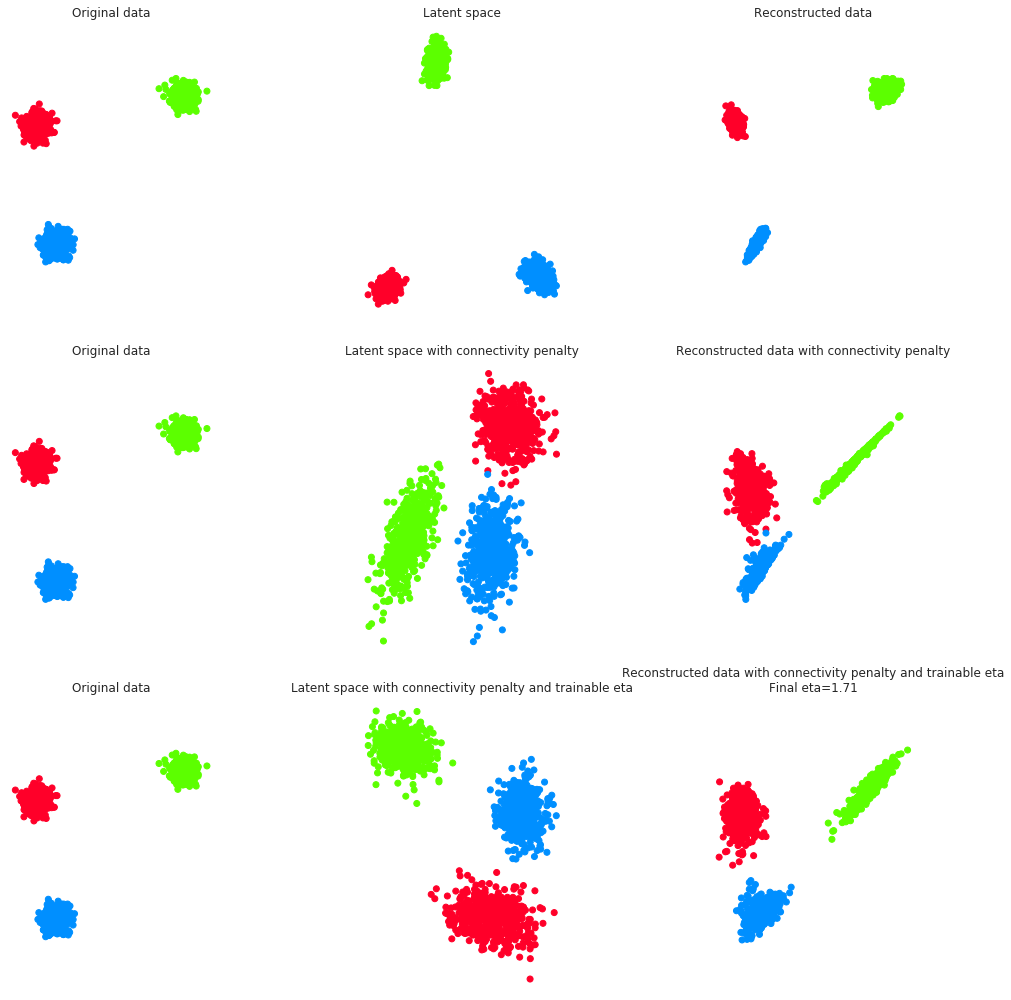

[0.0034031335, 0.10431740870867036, 6.932193]
[0.00076490396, 0.03374859362621956, 5.8047]
[0.0018764766, 0.06922236691322861, 1.5172049]


In [5]:
fig, axes = plt.subplots(figsize=(14, 14), nrows=3, ncols=3)

ax = axes[0, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')
ax.axis('off')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')
ax.axis('off')

ax = axes[1, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[1, 1]
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')
ax.axis('off')

ax = axes[1, 2]
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty')
ax.axis('off')

ax = axes[2, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[2, 1]
latent_space_penalty = model_penalty_trainable_eta.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty and trainable eta')
ax.axis('off')

ax = axes[2, 2]
reconstructed_data = model_penalty_trainable_eta.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty and trainable eta\nFinal eta={:.2f}'\
             .format(model_penalty_trainable_eta.connectivity_layer.eta.item()))
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('gaussian_trainable_eta.eps')

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))